# <span style="color:#1576BB">Caso de Estudio 2: 
</span>

**Curso:** Deep Learning

---
 **Desarrollado por:**

Juan Camilo Sanmiguel 
Jonathan Alejandro Rubiano

### 1. Descripción del Problema

En este nuevo caso de estudio, se exploraría el uso de Transfer Learning, aprovechando modelos preentrenados para mejorar la clasificación en las mismas categorías:

**El objetivo principal es:**

El objetivo es comparar el desempeño de un modelo entrenado desde cero con el de un modelo preentrenado ajustado a este conjunto de datos, optimizando el tiempo de entrenamiento y la precisi´on
de la clasificación.

Trabajaremos con el recurso COVID-19 Radiography Database, reconocido con el *COVID-19 Dataset* Award por la comunidad de Kaggle. Este conjunto de datos fue recopilado por investigadores de
la Universidad de Qatar (Qatar), la Universidad de Dhaka (Bangladesh) y colaboradores de Pakistán
y Malasia, junto con médicos. Contiene miles de radiograf´ıas clasificadas como:
- COVID-19, casos confirmados.
- Normal, pacientes sin hallazgos patológicos.
- Viral Pneumonia, neumonía viral distinta de COVID-19.
- Lung Opacity, opacidades pulmonares no relacionadas con COVID-19.

## Preprocesamiento de los datos

Se descargaron los datos desde el repositorio en Kaggle

Se aplico CLAHE como una mejora de contraste activo, eligiendo parámetros CLIP = 2 y GRID = 8, se realizó el ajuste de tamaño para poder usarse dentro de un modelo ya definido a un resize (224×224), padding para evitar pérdidas de información en el cambio de tamaño, normalización y conversión a RGB.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("tawsifurrahman/covid19-radiography-database")

print("Path to dataset files:", path)

100%|██████████| 778M/778M [00:13<00:00, 59.4MB/s] 

Extracting files...


Path to dataset files: C:\Users\Camilo\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5


In [ ]:
import tensorflow as tf
print("TensorFlow:", tf.__version__)
print("Dispositivos GPU:", tf.config.list_physical_devices('GPU'))


TensorFlow: 2.20.0
Dispositivos GPU: []


In [ ]:
C:\Users\Camilo\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5\COVID-19_Radiography_Dataset

In [ ]:
import os
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.3/bin")
os.add_dll_directory("C:/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v12.3/libnvvp")

import tensorflow as tf

print("TensorFlow:", tf.__version__)
print("GPUs disponibles:", tf.config.list_physical_devices('GPU'))

# Prueba de operación en GPU
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)
print("Operación completada correctamente.")


TensorFlow: 2.20.0
GPUs disponibles: []
Operación completada correctamente.


In [ ]:
# ============================================================
# 🧠 ENTRENAMIENTO DE CLASIFICADOR MULTICLASE CON EFFICIENTNETB0
# ============================================================

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ============================================================
# 📂 CONFIGURACIÓN DE RUTAS
# ============================================================/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset

# Ruta principal que contiene las 4 carpetas de categorías
base_dir = r"C:\Users\Camilo\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5\COVID-19_Radiography_Dataset"
IMG_SIZE = 224
TEST_SIZE = 0.2
BATCH_SIZE = 16
EPOCHS = 50
LEARNING_RATE = 1e-4

# CLAHE params
CLAHE_CLIP = 2.0
CLAHE_GRID = (8, 8)

# ============================================================
# FUNCIONES AUXILIARES
# ============================================================
def apply_clahe_and_resize_gray(path, img_size=IMG_SIZE, clip=CLAHE_CLIP, grid=CLAHE_GRID):
    """
    Lee imagen en grayscale, aplica CLAHE, redimensiona manteniendo aspecto con padding,
    devuelve imagen uint8 en escala 0-255 (single-channel).
    """
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"No se pudo leer: {path}")

    # Aplicar CLAHE
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=grid)
    enhanced = clahe.apply(img)

    # Resize manteniendo aspecto y padding centrado
    h, w = enhanced.shape
    scale = img_size / max(h, w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(enhanced, (new_w, new_h), interpolation=cv2.INTER_AREA)

    padded = np.zeros((img_size, img_size), dtype=np.uint8)
    x_offset = (img_size - new_w) // 2
    y_offset = (img_size - new_h) // 2
    padded[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

    return padded  # uint8 (0-255), single channel


def gray_to_rgb_stack(gray_img):
    """
    Convierte imagen (H,W) uint8 a (H,W,3) replicando el canal.
    """
    if gray_img.ndim == 2:
        return np.stack((gray_img,)*3, axis=-1)
    elif gray_img.ndim == 3 and gray_img.shape[2] == 1:
        return np.concatenate([gray_img]*3, axis=-1)
    else:
        return gray_img  # ya RGB
    

Se realizo la unión de los datos con sus respectivas categorías para poder ser usados dentro del modelo de Deep learning.

In [ ]:
# ============================================================
# CONSTRUIR DATAFRAME con rutas e etiquetas (categorías)
# ============================================================
data = []
for category in sorted(os.listdir(base_dir)):
    category_path = os.path.join(base_dir, category)
    images_dir = os.path.join(category_path, "images")
    if not os.path.isdir(images_dir):
        print(f"⚠️ No se encontró 'imagenes' en {category_path}, se omite")
        continue
    for fn in sorted(os.listdir(images_dir)):
        if fn.lower().endswith((".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff")):
            data.append({"ruta_imagen": os.path.join(images_dir, fn), "categoria": category})

df = pd.DataFrame(data)
if df.empty:
    raise SystemExit("No se encontraron imágenes. Revisa base_dir y estructura de carpetas.")
print(f"✅ Dataset creado: {len(df)} imágenes, {df['categoria'].nunique()} clases")
print(df['categoria'].value_counts())


⚠️ No se encontró 'imagenes' en C:\Users\Camilo\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5\COVID-19_Radiography_Dataset\COVID.metadata.xlsx, se omite
⚠️ No se encontró 'imagenes' en C:\Users\Camilo\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5\COVID-19_Radiography_Dataset\Lung_Opacity.metadata.xlsx, se omite
⚠️ No se encontró 'imagenes' en C:\Users\Camilo\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5\COVID-19_Radiography_Dataset\Normal.metadata.xlsx, se omite
⚠️ No se encontró 'imagenes' en C:\Users\Camilo\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5\COVID-19_Radiography_Dataset\README.md.txt, se omite
⚠️ No se encontró 'imagenes' en C:\Users\Camilo\.cache\kagglehub\datasets\tawsifurrahman\covid19-radiography-database\versions\5\COVID-19_Radiography_Dataset\Viral Pneumonia.metadata.xlsx, se omite
✅ Dataset creado: 21165 imágenes, 4 clases
categ

In [ ]:
# ============================================================
# MAPEO DE CLASES Y CARGA + PREPROCESAMIENTO (CLAHE + STACK + preprocess_input)
# ============================================================
class_names = sorted(df["categoria"].unique())
class_to_idx = {name: idx for idx, name in enumerate(class_names)}
print("Clases:", class_to_idx)

X_list, y_list = [], []
for idx, row in df.iterrows():
    p = row["ruta_imagen"]
    label = class_to_idx[row["categoria"]]
    try:
        gray = apply_clahe_and_resize_gray(p, img_size=IMG_SIZE)
        rgb = gray_to_rgb_stack(gray)                     # -> H,W,3 uint8
        X_list.append(rgb)
        y_list.append(label)
    except Exception as e:
        print(f"⚠️ Error cargando {p}: {e}")

X = np.array(X_list, dtype=np.uint8)   # shape (N, H, W, 3) uint8
y = np.array(y_list, dtype=np.int32)

print(f"✅ Imágenes cargadas en memoria: {X.shape}, etiquetas: {y.shape}")


Clases: {'COVID': 0, 'Lung_Opacity': 1, 'Normal': 2, 'Viral Pneumonia': 3}
✅ Imágenes cargadas en memoria: (21165, 224, 224, 3), etiquetas: (21165,)


In [ ]:
# ============================================================
# NORMALIZACIÓN: usar preprocess_input (EfficientNet espera [-1,1])
# ============================================================
# Convertir a float32 primero
X = X.astype(np.float32)
X = preprocess_input(X)   # esto ajusta según EfficientNet (usa escala -1..1)
y_cat = to_categorical(y, num_classes=len(class_names))

Adicional se realizó un aumento de datos por medio ImageDataGenerator donde se utilizó: 
-	Rotación de 15°
-	Movimiento en ejes horizontal y vertical de 10% 
-	Una variación de aumento de 10%
-	Una inversión de la mitad de las imágenes creadas en el eje horizontal 
-	Y relleno de las imágenes donde queden espacios negros utilizando los pixeles mas cercanos


In [ ]:
# ============================================================
# SPLIT TRAIN/TEST
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=TEST_SIZE, random_state=42, stratify=y_cat
)
print(f"Split: train={X_train.shape[0]}, test={X_test.shape[0]}")

# ============================================================
# DATA AUGMENTATION
# ============================================================
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


Split: train=16932, test=4233


In [ ]:
import tensorflow as tf

Se definió utilizar EfficientNET debido a sus ventajas de eficiencia al ser uno de los primeros modelos en incluir un escalado compuesto le permite tener mayor precisión con menos parámetros. Además de tener varias versiones que permiten escalar el modelo de manera más precisa. 

Debido a lo anterior se seleccionó el modelo más pequeño el B0, logrando tener un modelo con buena precisión pero que se mantenga económico en recursos computacionales tratándose de un ámbito académico. 


In [ ]:
# ============================================================
# LIMPIAR SESSION PREVIA (evita cargar pesos antiguos inconsistentes)
# ============================================================
tf.keras.backend.clear_session()

# ============================================================
# MODELO: EfficientNetB0 (INPUT 3 CANALES) - clave: input_shape=(224,224,3)
# ============================================================

# Instanciar sin pesos primero
base_model = EfficientNetB0(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Descargar y cargar pesos manualmente
weights_url = "https://storage.googleapis.com/keras-applications/efficientnetb0_notop.h5"
weights_path = tf.keras.utils.get_file("efficientnetb0_notop.h5", origin=weights_url, cache_subdir="models")
base_model.load_weights(weights_path)

# Congelar base (igual que antes)
for layer in base_model.layers:
    layer.trainable = False

# Agregar top personalizado (igual que antes)
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compilar (igual que antes)
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

print("\nResumen del modelo (asegúrate INPUT 3 canales):")
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

Resumen del modelo (asegúrate INPUT 3 canales):


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ normalization[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_

 Total params: 20,107,175 (76.70 MB)

 Trainable params: 16,057,604 (61.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Utilizando el aprendizaje el taller anterior se siguieron aplicando las funciones de early stopping para detener el modelo en el caso de no ver una mejora notoria entre épocas de entrenamiento y se aplico ReduceLROnPlateau para tener una tasa de aprendizaje dinámica y seguir optimizando los recursos en el entrenamiento. 

In [ ]:
# ============================================================
# CALLBACKS
# ============================================================
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, mode='max', restore_best_weights=True, verbose=1)
lr_plateau = ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# ============================================================
# ENTRENAMIENTO
# ============================================================
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    callbacks=[early_stopping, lr_plateau],
    verbose=1
)


c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 427s 397ms/step - accuracy: 0.7897 - loss: 0.5670 - val_accuracy: 0.8344 - val_loss: 0.4268 - learning_rate: 1.0000e-04
Epoch 2/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 408s 385ms/step - accuracy: 0.8397 - loss: 0.4279 - val_accuracy: 0.8535 - val_loss: 0.3892 - learning_rate: 1.0000e-04
Epoch 3/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 411s 388ms/step - accuracy: 0.8578 - loss: 0.3793 - val_accuracy: 0.8715 - val_loss: 0.3554 - learning_rate: 1.0000e-04
Epoch 4/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 406s 383ms/step - accuracy: 0.8643 - loss: 0.3679 - val_accuracy: 0.8819 - val_loss: 0.3198 - learning_rate: 1.0000e-04
Epoch 5/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 404s 382ms/step - accuracy: 0.8737 - loss: 0.3457 - val_accuracy: 0.8715 - val_loss: 0.3645 - learning_rate: 1.0000e-04
Epoch 6/50
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 407s 384ms/step - accuracy: 0.8799 - loss: 0.3333 - val_accuracy: 0.8724 - val_loss: 0.3498 - learning_rate: 1.0000e-04
Epoch 7/50
1059/1059 ━━━━━━━


🎯 Precisión en test: 90.22%


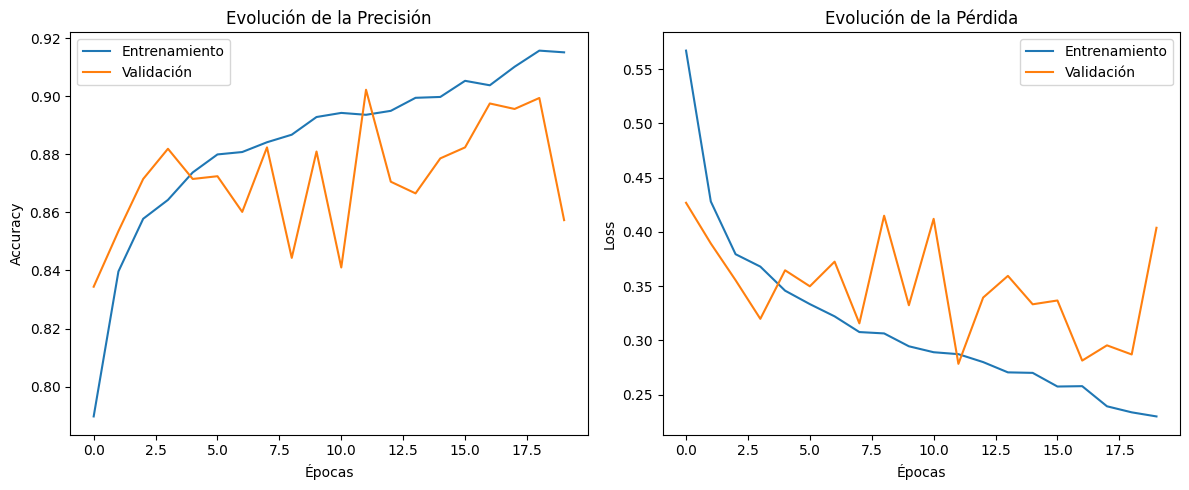

133/133 ━━━━━━━━━━━━━━━━━━━━ 65s 473ms/step


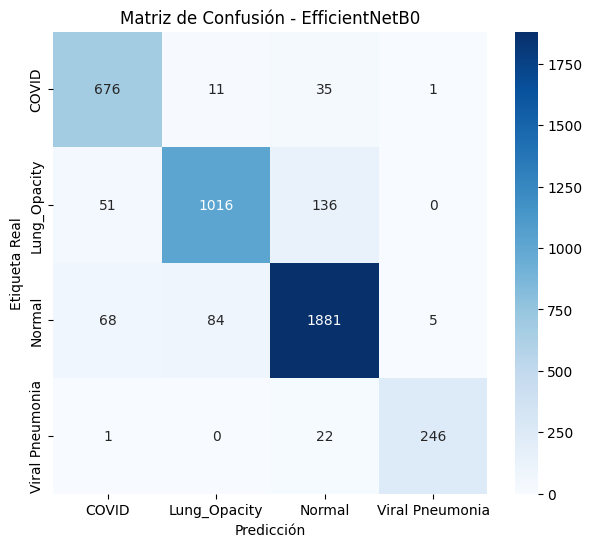

In [ ]:
# ============================================================
# EVALUACIÓN Y GRAFICAS
# ============================================================
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🎯 Precisión en test: {acc*100:.2f}%")

# Curvas
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Matriz de confusión
y_pred = model.predict(X_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión - EfficientNetB0")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predicciones en test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte de métricas por clase
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


133/133 ━━━━━━━━━━━━━━━━━━━━ 63s 471ms/step
                 precision    recall  f1-score   support

          COVID       0.85      0.93      0.89       723
   Lung_Opacity       0.91      0.84      0.88      1203
         Normal       0.91      0.92      0.91      2038
Viral Pneumonia       0.98      0.91      0.94       269

       accuracy                           0.90      4233
      macro avg       0.91      0.90      0.91      4233
   weighted avg       0.90      0.90      0.90      4233



In [ ]:

model.save("modelo_covid.keras")
print("✅ Modelo guardado exitosamente como 'modelo_covid.h5'")

✅ Modelo guardado exitosamente como 'modelo_covid.h5'


In [ ]:
model = tf.keras.models.load_model("modelo_covid.h5")
base_model = model.layers[1]  # EfficientNet dentro del modelo

## Descongelar capas

In [23]:
# ============================================================
# FINE-TUNING: Descongelar las últimas 20 capas de TODO el modelo
# ============================================================

from tensorflow.keras.optimizers import Adam

# Ver cuántas capas totales tiene el modelo (ya incluye EfficientNet)
print(f"Número total de capas en el modelo completo: {len(model.layers)}")

# Descongelar las últimas 20 capas
for layer in model.layers[-20:]:
    layer.trainable = True

# Comprobación (opcional)
trainable_count = sum([layer.trainable for layer in model.layers])
print(f"🔓 Capas entrenables después del cambio: {trainable_count}")

# Recompilar con learning rate bajo
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\n🔄 Iniciando fine-tuning (últimas 20 capas del modelo)...")

# Entrenamiento adicional (pocas épocas)
history_finetune = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=10,
    callbacks=[early_stopping, lr_plateau],
    verbose=1
)

# Evaluar nuevamente
loss_ft, acc_ft = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🔹 Precisión tras fine-tuning: {acc_ft*100:.2f}%")


Número total de capas en el modelo completo: 241
🔓 Capas entrenables después del cambio: 21

🔄 Iniciando fine-tuning (últimas 20 capas del modelo)...
Epoch 1/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 479s 445ms/step - accuracy: 0.8207 - loss: 0.7993 - val_accuracy: 0.8838 - val_loss: 0.3688 - learning_rate: 1.0000e-05
Epoch 2/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 464s 438ms/step - accuracy: 0.8663 - loss: 0.4067 - val_accuracy: 0.8783 - val_loss: 0.3497 - learning_rate: 1.0000e-05
Epoch 3/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 462s 437ms/step - accuracy: 0.8816 - loss: 0.3313 - val_accuracy: 0.8826 - val_loss: 0.3273 - learning_rate: 1.0000e-05
Epoch 4/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 464s 438ms/step - accuracy: 0.8901 - loss: 0.3058 - val_accuracy: 0.8826 - val_loss: 0.3263 - learning_rate: 1.0000e-05
Epoch 5/10
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step - accuracy: 0.8909 - loss: 0.2843
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 470s 


🎯 Precisión en test: 87.69%


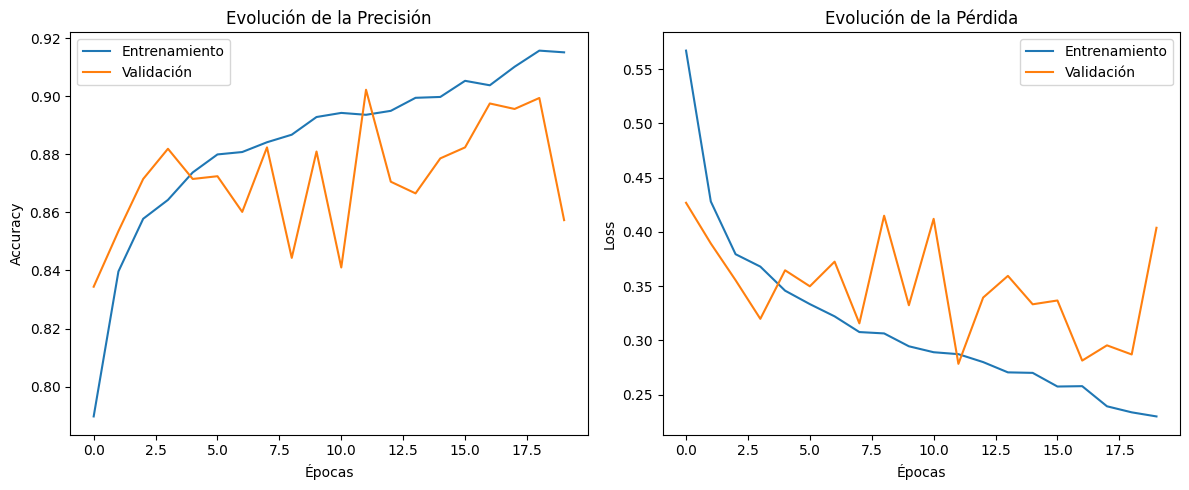

133/133 ━━━━━━━━━━━━━━━━━━━━ 65s 473ms/step


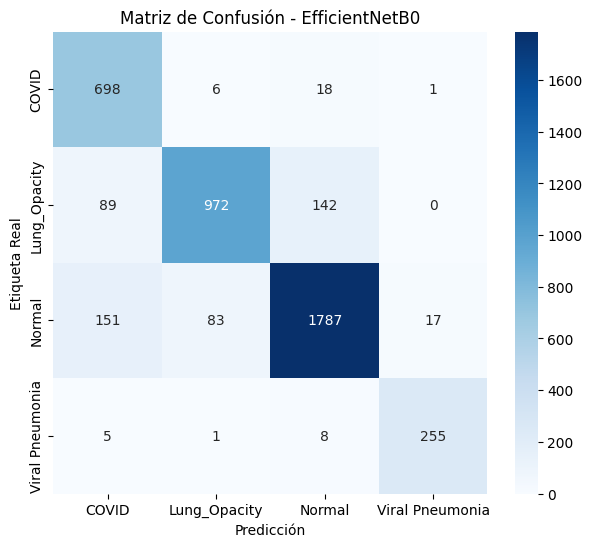

In [25]:
# ============================================================
# EVALUACIÓN Y GRAFICAS  DESPUES DE DESCONGELAR
# ============================================================
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\n🎯 Precisión en test: {acc*100:.2f}%")

# Curvas
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Evolución de la Precisión')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Evolución de la Pérdida')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Matriz de confusión
y_pred = model.predict(X_test)
y_true_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true_labels, y_pred_labels)

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Matriz de Confusión - EfficientNetB0")
plt.xlabel("Predicción")
plt.ylabel("Etiqueta Real")
plt.show()


In [26]:
### Metricas despues de descongelar capas 
# Predicciones en test
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Reporte de métricas por clase
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_classes, target_names=class_names))


133/133 ━━━━━━━━━━━━━━━━━━━━ 61s 458ms/step
                 precision    recall  f1-score   support

          COVID       0.74      0.97      0.84       723
   Lung_Opacity       0.92      0.81      0.86      1203
         Normal       0.91      0.88      0.90      2038
Viral Pneumonia       0.93      0.95      0.94       269

       accuracy                           0.88      4233
      macro avg       0.88      0.90      0.88      4233
   weighted avg       0.89      0.88      0.88      4233



In [17]:
# ============================================================
# COMPARACIÓN: Modelo entrenado desde cero vs Transfer Learning
# ============================================================

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

# Modelo desde cero (sin pesos preentrenados)
base_scratch = EfficientNetB0(weights=None, include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = Flatten()(base_scratch.output)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation="softmax")(x)

model_scratch = Model(inputs=base_scratch.input, outputs=output)

model_scratch.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print("\nEntrenando modelo desde cero (sin transfer learning)...")

# Entrenamos solo unas pocas épocas (para comparación rápida)
history_scratch = model_scratch.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_test, y_test),
    epochs=8,
    verbose=1
)

# Evaluar desempeño
loss_scratch, acc_scratch = model_scratch.evaluate(X_test, y_test, verbose=0)
print(f"\n🔹 Precisión modelo desde cero: {acc_scratch*100:.2f}%")

# ============================================================
# COMPARACIÓN FINAL
# ============================================================

# Supongamos que el modelo con Transfer Learning ya se llama "model"
loss_tl, acc_tl = model.evaluate(X_test, y_test, verbose=0)

print("\n================ COMPARACIÓN FINAL ================")
print(f"Modelo desde cero       : {acc_scratch*100:.2f}%")
print(f"Modelo Transfer Learning: {acc_tl*100:.2f}%")
print("===================================================")



Entrenando modelo desde cero (sin transfer learning)...


c:\Users\Camilo\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/8
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 1778s 2s/step - accuracy: 0.5679 - loss: 1.0840 - val_accuracy: 0.6825 - val_loss: 0.7972
Epoch 2/8
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 1651s 2s/step - accuracy: 0.6738 - loss: 0.8356 - val_accuracy: 0.7361 - val_loss: 0.6830
Epoch 3/8
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 1629s 2s/step - accuracy: 0.7107 - loss: 0.7533 - val_accuracy: 0.7569 - val_loss: 0.6390
Epoch 4/8
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 1759s 2s/step - accuracy: 0.7330 - loss: 0.6898 - val_accuracy: 0.7616 - val_loss: 0.6342
Epoch 5/8
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 1681s 2s/step - accuracy: 0.7599 - loss: 0.6344 - val_accuracy: 0.7763 - val_loss: 0.5953
Epoch 6/8
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 1708s 2s/step - accuracy: 0.7725 - loss: 0.5983 - val_accuracy: 0.7935 - val_loss: 0.5366
Epoch 7/8
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 1702s 2s/step - accuracy: 0.7897 - loss: 0.5688 - val_accuracy: 0.7947 - val_loss: 0.6172
Epoch 8/8
1059/1059 ━━━━━━━━━━━━━━━━━━━━ 1706s 2s/step - accuracy: 0.8045 - loss: 0

## Conclusiones

- **Desempeño del modelo:**  
  EfficientNet demostró un **excelente rendimiento**, alcanzando alta precisión con un número limitado de épocas de entrenamiento.  
  El uso de **transfer learning** fue clave, ya que permitió aprovechar el conocimiento previo de redes preentrenadas, mejorando notablemente las métricas de desempeño sin necesidad de entrenar desde cero.

- **Importancia del preprocesamiento:**  
  Herramientas como **CLAHE**, la **normalización** y el **data augmentation** desempeñaron un papel fundamental.  
  Su combinación permitió obtener un modelo **robusto, eficaz y eficiente**, capaz de generalizar mejor frente a variaciones en las imágenes.

- **Estrategia de aumento de datos:**  
  La técnica de data augmentation es muy útil ante la limitación de datos reales, ya que genera imágenes sintéticas que enriquecen el conjunto de entrenamiento.  
  Sin embargo, es importante ajustar cuidadosamente los parámetros en este caso, las radiografías estaban centradas, lo que permitió realizar pequeñas rotaciones , zoom y desplazamientos sin perder información relevante.  
  En otros escenarios, una configuración inadecuada podría introducir ruido o distorsionar características crítica, afectando negativamente el aprendizaje del modelo.


